In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

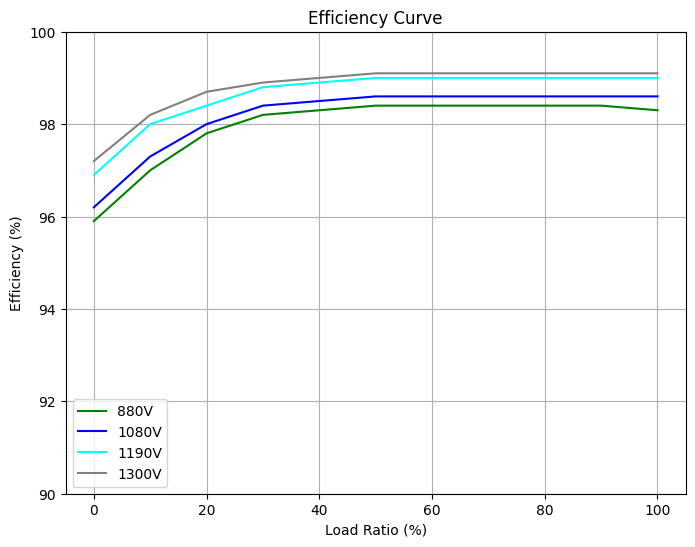

In [2]:
# Load ratio values (0 to 100%)
load_ratios = np.linspace(0, 100, 11)

# Efficiency values based on the graph's observed data (approximation for each voltage)
efficiency_880V = [95.9, 97, 97.8, 98.2, 98.3, 98.4, 98.4, 98.4, 98.4, 98.4, 98.3]
efficiency_1080V = [96.2, 97.3, 98, 98.4, 98.5, 98.6, 98.6, 98.6, 98.6, 98.6, 98.6]
efficiency_1190V = [96.9, 98, 98.4, 98.8, 98.9, 99, 99, 99, 99, 99, 99]
efficiency_1300V = [97.2, 98.2, 98.7, 98.9, 99, 99.1, 99.1, 99.1, 99.1, 99.1, 99.1]

# Plot the efficiency curves for different voltages
plt.figure(figsize=(8,6))
plt.plot(load_ratios, efficiency_880V, label='880V', color='green')
plt.plot(load_ratios, efficiency_1080V, label='1080V', color='blue')
plt.plot(load_ratios, efficiency_1190V, label='1190V', color='cyan')
plt.plot(load_ratios, efficiency_1300V, label='1300V', color='grey')

# Graph Labels and Title
plt.title('Efficiency Curve')
plt.xlabel('Load Ratio (%)')
plt.ylabel('Efficiency (%)')
plt.legend()
plt.grid(True)
plt.ylim([90, 100])

# Display the plot
plt.show()

In [3]:
# Define the known load ratios (multiples of 10)
known_load_ratios = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Map the voltage values to their corresponding efficiency curves
efficiency_curves = {
    880: efficiency_880V,
    1080: efficiency_1080V,
    1190: efficiency_1190V,
    1300: efficiency_1300V
}

# Function to interpolate efficiency based on load ratio
def interpolate_load_ratio_efficiency(load_ratio, known_load_ratios, known_efficiencies):
    # Find the nearest lower and higher load ratios for interpolation
    lower_index = np.searchsorted(known_load_ratios, load_ratio) - 1
    upper_index = lower_index + 1

    # Boundary conditions: if load_ratio is below or above the known range
    if lower_index < 0:
        return known_efficiencies[0]  # Return the efficiency at the lowest load ratio
    if upper_index >= len(known_load_ratios):
        return known_efficiencies[-1]  # Return the efficiency at the highest load ratio

    # Get the known points for interpolation
    x1, y1 = known_load_ratios[lower_index], known_efficiencies[lower_index]
    x2, y2 = known_load_ratios[upper_index], known_efficiencies[upper_index]

    # Linear interpolation
    efficiency = y1 + (load_ratio - x1) / (x2 - x1) * (y2 - y1)
    return efficiency

# Function to find nearest voltages
def find_nearest_voltages(target_voltage, available_voltages):
    available_voltages = sorted(available_voltages)
    low_voltage = None
    high_voltage = None
    for voltage in available_voltages:
        if voltage <= target_voltage:
            low_voltage = voltage
        if voltage >= target_voltage:
            high_voltage = voltage
            break
    return low_voltage, high_voltage

# Main function to get efficiency based on both voltage and load ratio
def get_efficiency(target_voltage, load_ratio):
    # Known voltages
    available_voltages = list(efficiency_curves.keys())

    # Check if target voltage matches one of the known voltages
    if target_voltage in available_voltages:
        # Directly return efficiency for that voltage (with load ratio interpolation if needed)
        known_efficiencies = efficiency_curves[target_voltage]
        return interpolate_load_ratio_efficiency(load_ratio, known_load_ratios, known_efficiencies)

    # If target voltage is not directly known, interpolate between the nearest voltages
    low_voltage, high_voltage = find_nearest_voltages(target_voltage, available_voltages)

    if low_voltage is None or high_voltage is None:
        return 98

    # Get efficiency for the low voltage (interpolated by load ratio)
    low_efficiency = interpolate_load_ratio_efficiency(load_ratio, known_load_ratios, efficiency_curves[low_voltage])

    # Get efficiency for the high voltage (interpolated by load ratio)
    high_efficiency = interpolate_load_ratio_efficiency(load_ratio, known_load_ratios, efficiency_curves[high_voltage])

    # Interpolate between the two voltages to find the target voltage efficiency
    efficiency_target = low_efficiency + (target_voltage - low_voltage) / (high_voltage - low_voltage) * (high_efficiency - low_efficiency)
    
    return efficiency_target

# Example usage
target_voltage = 1300  # Target voltage
load_ratio = 30  # Target load ratio

# Calculate the efficiency
efficiency = get_efficiency(target_voltage, load_ratio)
print(f"Estimated efficiency at {target_voltage}V and {load_ratio}% load ratio: {efficiency:.2f}%")

Estimated efficiency at 1300V and 30% load ratio: 98.90%


In [6]:
def get_vac(i, vdc, vph = 240, pf = 1):   #Predict the AC voltage according to the efficiency curve
    idc = 0
    for j in i:
        idc += j
    
    pdc = idc*vdc
    load_ratio = pdc*100/100000
    eff = get_efficiency(vdc, load_ratio)
    pac = pdc*eff
    iph = pac/(vph*(3**0.5)*pf)

    return [pac, pdc, idc, iph]

In [4]:
df = pd.read_csv('dataSample1.csv')
smb_columns = ['SMB1 Total Current(A)', 'SMB2 Total Current(A)', 'SMB3 Total Current(A)', 
               'SMB4 Total Current(A)', 'SMB5 Total Current(A)', 'SMB6 Total Current(A)', 
               'SMB7 Total Current(A)']

vdc_columns = ['DC Voltage (V)']

# Create the 2D array with only SMB currents
smb_current_array = df[smb_columns].values

# Create the array with only DC voltages
vdc_array = df[vdc_columns].values

# Optionally, print the first 5 rows for inspection
print(smb_current_array[600:605])
print(vdc_array[600:605])

[[185.9 184.  184.2 184.1 182.7 185.9 185.4]
 [152.2 152.  149.  146.  150.3 150.6 148.7]
 [168.7 169.5 169.4 169.3 169.2 170.3 172. ]
 [178.8 181.  179.6 179.1 180.3 170.3 172. ]
 [178.8 181.  179.6 179.1 180.3 181.6 179.4]]
[[674]
 [704]
 [691]
 [690]
 [692]]


In [8]:
pac = []
for i in range(0, len(smb_current_array)): # Predict the AC power for each row
    pac.append(get_vac(smb_current_array[i], vdc_array[i])[0])

pac_act = df['AC Power (kW)'].values # Power AC Actual

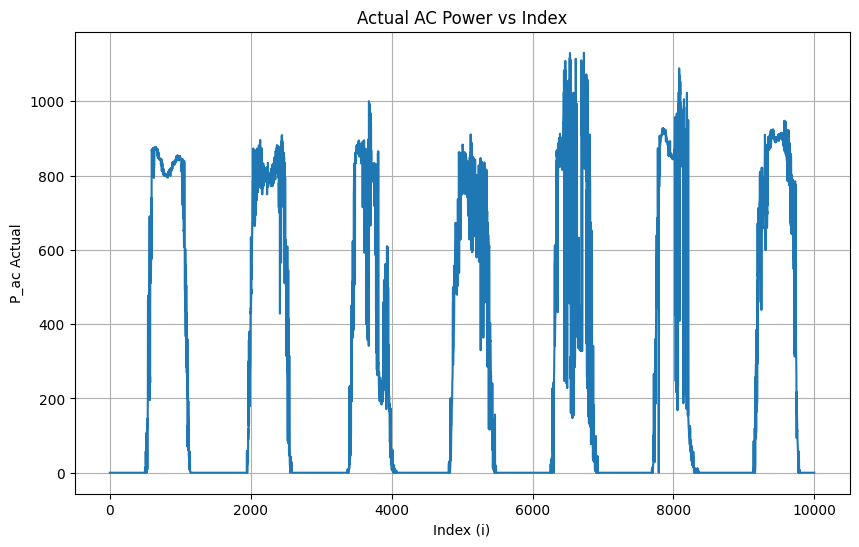

In [9]:
plt.figure(figsize=(10,6))
plt.plot(range(10000), pac_act[:10000])
plt.title('Actual AC Power vs Index')
plt.xlabel('Index (i)')
plt.ylabel('P_ac Actual')
plt.grid(True)
plt.show()

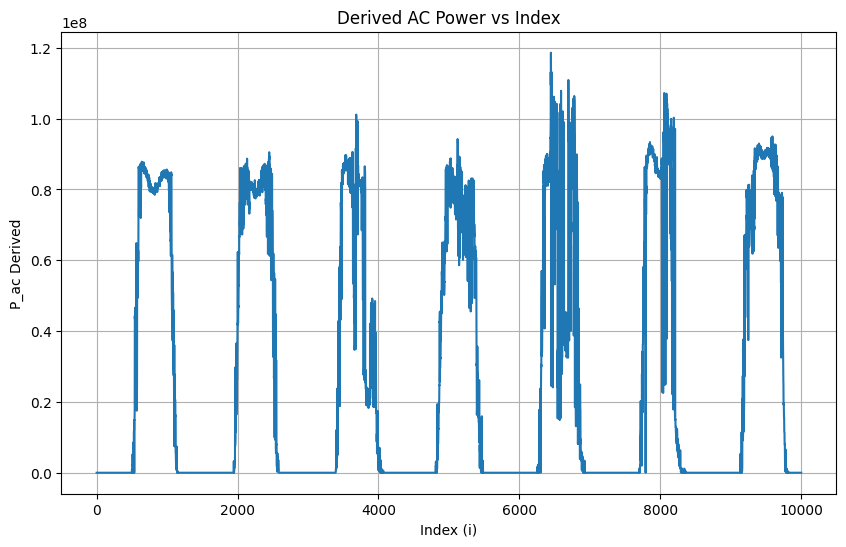

In [10]:
plt.figure(figsize=(10,6))
plt.plot(range(10000), pac[:10000])
plt.title('Derived AC Power vs Index')
plt.xlabel('Index (i)')
plt.ylabel('P_ac Derived')
plt.grid(True)
plt.show()